<div class="row">
    <div class="column">
        <img src="https://datasciencecampus.ons.gov.uk/wp-content/uploads/sites/10/2017/03/data-science-campus-logo-new.svg"
             alt="Data Science Campus Logo"
             align="right" 
             width = "340"
             style="margin: 0px 60px"
             />
    </div>
    <div class="column">
        <img src="https://cdn.ons.gov.uk/assets/images/ons-logo/v2/ons-logo.svg"
             alt="ONS Logo"
             align="left" 
             width = "420"
             style="margin: 0px 30px"/>
    </div>
</div>

In [2]:
# Standard imports
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import RegularPolygon
import numpy as np
import random
from scipy.stats import binom, poisson, chisquare

# Geospatial (NB shapely is a geopandas dependency)
import geopandas as gpd
from shapely.geometry import Polygon, Point

%matplotlib inline

# Generate a set of hexagons

This will be our grid which will act as the analysis frame, think of it as a fancy quadrat.

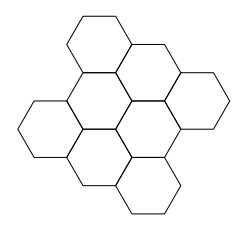

In [7]:
# Triangular coordinates for hexagons (x,y,z)
coord = [[0,0,0],[0,1,-1],[-1,0,1],[0,-1,1],[1,-1,0],[1,0,-1],[2,1,1],[1,-2,1]]
# Horizontal cartesian coords
hcoord = [c[0] for c in coord]
# Vertical cartesian coords
vcoord = [2. * np.sin(np.radians(60)) * (c[1] - c[2]) /3. for c in coord]

geom = []
for xy in zip(hcoord, vcoord):
    # Use matplotlib to create hexagons
    hexagon = RegularPolygon(xy, numVertices=6, radius=2. / 3., orientation=np.radians(30))
    geom.append(Polygon(hexagon.get_verts()))

# make hexagons a geodataframe
base = gpd.GeoDataFrame({'id':pd.Categorical(list(range(1,9)))}, geometry = geom)

# See what hexagons look like
ax = base.plot(facecolor = 'None', edgecolor = 'k')
ax.set_xticks([]); ax.set_yticks([]); ax.set_aspect('equal')
ax.set_axis_off();

# Generate Random Point Pattern

Pattern is generated within area covered by hexagons.

In [4]:
def random_points(n, polygons):
    # Generate n random points within polygons.
    dissolved_poly = polygons.assign(diss=1).dissolve(by='diss')['geometry'].values[0]
    points = [_get_random_point_in_polygon(dissolved_poly) for _ in range(n)]
    return gpd.GeoDataFrame(geometry = points)
    
def _get_random_point_in_polygon(poly):
    minx, miny, maxx, maxy = poly.bounds
    while True:
        p = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        if poly.contains(p):
            return p

# Plot Random Point Patterns

Plot 8 instances of a random point pattern of n points within the 8 hexagons. Just to get a sense of the diversity of random point patterns.

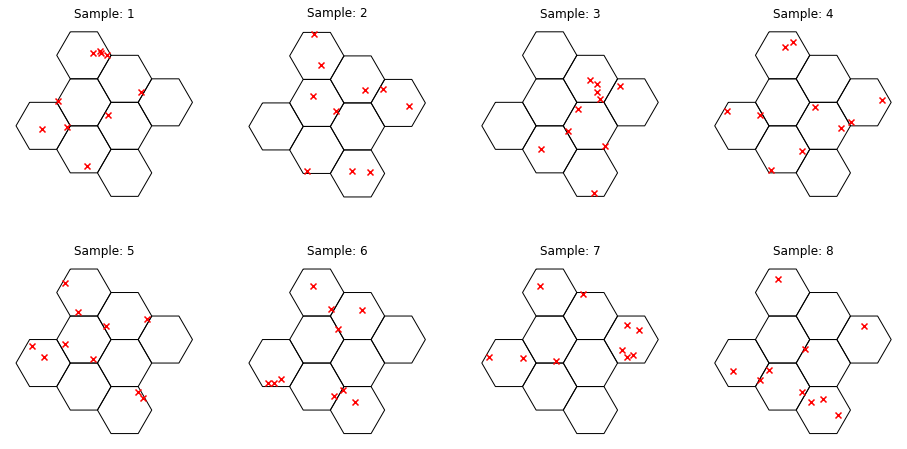

In [6]:
f, axes = plt.subplots(2,4, figsize = (16,8))

for idx, ax in enumerate(axes.flatten()):
    base.plot(facecolor = 'None', edgecolor = 'k', ax=ax)
    pnts = random_points(10, base)
    pnts.plot(c = 'r', marker = 'x', ax=ax)
    ax.set_aspect('equal')
    ax.set_axis_off()
    ax.set_title(f"Sample: {idx + 1}")

# Binomial Distribution

The Binomial distribution gives you the discrete probability distribution of the number of successes in a sequence of $n$ independent experiments, each asking a yes–no question, and each with its own boolean-valued outcome: success/yes/true/one (with probability $p$) or failure/no/false/zero (with probability $q = 1 − p$).

## General Formula

$$P(k\ \mathrm{events}) = C_{k}^{n} \times \left ( p \right )^{k} \times \left ( q \right )^{n - k}$$

Where,  
$k$ is the number of successes,  
$n$ is the number of trials,  
$p$ is the probability of success in any single series of a trial,  
$q$ is the probability of failure in any single series of a trial,  
$C_{k}^{n}$ is the number of ways (combinations) in which an event can occur $k$ times in $n$ trials.

## Application to Space

In the example above, we're dropping points onto a hexagonal grid, giving us 10 trials ($n = 10$). The probability of a single point falling in a given hexagon is 1 in 8 ($\frac{1}{8}$) and the probability of failure is thus 7 in 8 ($\frac{7}{8}$). Logically, there are 10 ($n$) different ways in which a hexagon can contain only 1 point after all trials, each of the 10 points could have fallen in a given hexagon with all other points missing. By the same token, there is only 1 way that a hexagon contains no points after all trials - thats if all points miss the hexagon. The formula below give the probability of seeing hexagons with $k$ points inside them, if the points fell at random. 

$$P(k\ events) = C_{k}^{10} \times \left ( \frac{1}{8} \right )^{k} \times \left ( \frac{7}{8} \right )^{10 - k}$$

Where:  
$$C_{k}^{10} = \frac{10!}{k!(10-k)!}$$

The probability of distribution for counts of $k$ based on 8 hexagons and 10 points can then be calculated:

In [17]:
p_k = lambda n,k,p : (np.math.factorial(n) / (np.math.factorial(k) * np.math.factorial(n-k))) * (p)**k * (1-p)**(n-k)

# Get full probability mass function (k = 0...10)
[p_k(10, k, 1/8) for k in range(0,11)]

[0.2630755761638284,
 0.37582225166261196,
 0.24160001892596483,
 0.0920381024479866,
 0.02300952561199665,
 0.0039444901049137115,
 0.0004695821553468704,
 3.8333237171173096e-05,
 2.05356627702713e-06,
 6.51925802230835e-08,
 9.313225746154785e-10]

# Using the Binomial Distribution

Rather than write our own Binomial distribution each time, we can just use a statistical package.

Our distribution applied to space is: $B(10,\frac{1}{8})$

Having specified the distribution, we can get the value of the probability mass function (pmf) for a given value of $k$ to derive the distribution.

(The numbers look slightly different in the precision as python is log transforming the input and exponentiating the result to make large values more tractable).

In [19]:
# Binomial
rv = binom(10,1/8) # n (number of trials), p (prob. of success)

[rv.pmf(k) for k in range(11)] # k (Number of successes)

[0.2630755761638284,
 0.3758222516626124,
 0.2416000189259649,
 0.09203810244798677,
 0.02300952561199669,
 0.0039444901049137185,
 0.00046958215534687145,
 3.833323717117318e-05,
 2.0535662770271322e-06,
 6.519258022308375e-08,
 9.313225746154793e-10]

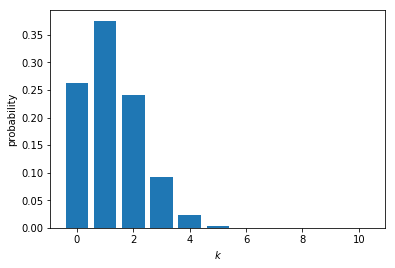

In [21]:
plt.bar(range(11),[rv.pmf(k) for k in range(11)])
plt.xlabel('$k$'); plt.ylabel('probability');

# Simulating the Binomial Distribution

Any single random sample of points on the hexagonal grid is unlikely to realise the exact distribution we see above, this is due to the nature of randomness and the small number of trials in this example.

The four graphs below are random realisations:

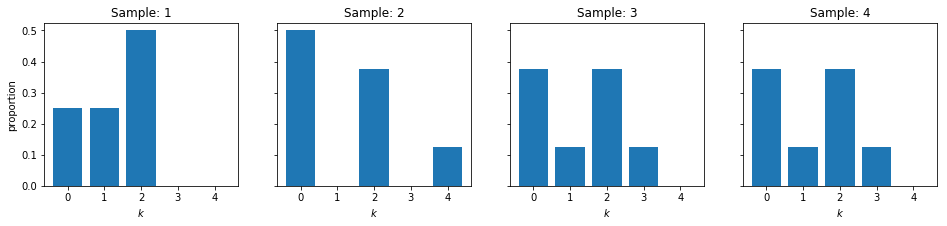

In [31]:
f, axes = plt.subplots(1,4, figsize = (16,3), sharex = True, sharey = True)

for i, ax in enumerate(axes):
    pnts = random_points(10, base)
    counts = (gpd.sjoin(pnts, base)
              .groupby('id')['id'].count()
              .value_counts(normalize = True)
              .sort_index())
    ax.bar(counts.index, counts)
    ax.set_xlabel('$k$')
    ax.set_title(f"Sample: {i+1}")
    
axes[0].set_ylabel('proportion');

However, if we conduct many experiments (i.e. take many samples), we find that the long run tends towards the theoretical values.

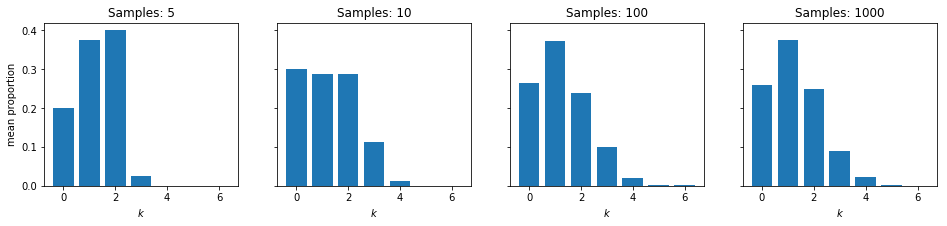

In [33]:
f, axes = plt.subplots(1,4, figsize = (16,3), sharex = True, sharey = True)

sims = {0:5,1:5,2:90,3:900}
labels = {0:5,1:10,2:100,3:1000}

counts = []

for i, ax in enumerate(axes):
    for rep in range(sims[i]):
        pnts = random_points(10, base)
        counts.append(gpd.sjoin(pnts, base)
                  .groupby('id')['id'].count()
                  .value_counts(normalize = True)
                  .sort_index())
    averages = pd.concat(counts, axis=1).fillna(0).mean(axis=1)
    ax.bar(averages.index, averages)
    ax.set_xlabel('$k$')
    ax.set_title(f"Samples: {labels[i]}")
    
axes[0].set_ylabel('mean proportion');

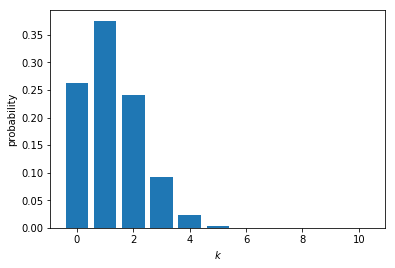

In [34]:
# Reminder of what the actual pmf looks like
plt.bar(range(11),[rv.pmf(k) for k in range(11)])
plt.xlabel('$k$'); plt.ylabel('probability');

# Testing an Observed Point Pattern

So far, we've generated random point patterns, however what if we observed a point pattern and wanted to test if it was likely to have occured as a result of a random process.

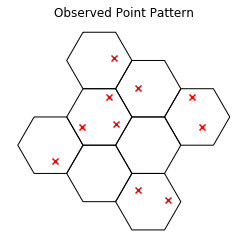

In [8]:
observed_points = [(0.3,1.2),(0.8, 0.6),(1.9, 0.4),(2.1,-0.2),(-0.9,-0.9),
                   (0.8,-1.5),(1.4,-1.7),(0.2, 0.4),(0.35,-0.15),(-0.35,-0.2)]

geom = [Point(x,y) for x,y in observed_points]
observed_points = gpd.GeoDataFrame(geometry = geom)

f, ax = plt.subplots()
base.plot(facecolor = 'none', edgecolor = 'k', ax=ax)
observed_points.plot(color = 'r', marker = 'x', ax=ax)
ax.set_aspect('equal'); ax.set_xticks([]); ax.set_yticks([]);
ax.set_title("Observed Point Pattern")
ax.set_axis_off();

Calculate the relative frequency of occurance of cells with 0,1,2,3...k points in them from the observed dataset and compare to the predicted probabilities given by the theoretical Binomial distribution.

In [90]:
probs = (gpd.sjoin(observed_points, base)
          .groupby('id')['id'].count()
          .value_counts(normalize = True)
          .sort_index()
          .rename('Observed Probability'))

theoretical = pd.Series([binom(10,1/8).pmf(k).round(6) for k in range(11)], name = 'Predicted Probability')

counts = (gpd.sjoin(observed_points, base)
          .groupby('id')['id'].count()
          .value_counts()
          .sort_index()
          .rename('Observed Counts'))

# Multiply probabilites by 8 to get expected counts
expected = pd.Series([(binom(10,1/8).pmf(k) * 8) for k in range(11)], name = 'Expected Counts')

# Make table
compare = pd.concat([probs,theoretical, counts, expected], axis=1).fillna(0)
compare

,Observed Probability,Predicted Probability,Observed Counts,Expected Counts
0,0.250,0.263076,2.0,2.104605e+00
1,0.375,0.375822,3.0,3.006578e+00
2,0.250,0.241600,2.0,1.932800e+00
3,0.125,0.092038,1.0,7.363048e-01
4,0.000,0.023010,0.0,1.840762e-01
5,0.000,0.003944,0.0,3.155592e-02
6,0.000,0.000470,0.0,3.756657e-03
7,0.000,0.000038,0.0,3.066659e-04
8,0.000,0.000002,0.0,1.642853e-05
9,0.000,0.000000,0.0,5.215406e-07


# Compute a Chi Square test ( $\chi^{2}$)

A chi square test tests the null hypothesis that the observed data has the expected frequencies. We provide the frequencies we would expect to see under spatial randomness and run the test.

Null Hypothesis ($H_{0}$) - The process is CSR - a completely random spatial process.  
Alternative Hypothesis ($H_{1}$) - The process is not CSR.

In [104]:
chi_test = chisquare(compare['Observed Counts'], compare['Expected Counts'])
(chi_test.statistic, chi_test.pvalue)

(0.32170033811036974, 0.9999992150803182)

The chi square test helps us conclude that it is extremely unlikely that the pattern is not completely spatially random, so we fail to reject the null hypothesis.

NB In practice we might truncate $k$ at 3 to avoid the cells with zero observed counts, and make the predicted probability for $k \geq 3$. This causes fewer issues with small numbers in the $\chi^{2}$ test.

# Using the Poisson Distribution

The Poisson distribution expresses the probability of a given number of events occurring in a fixed interval of time or space if these events occur with a known constant rate and independently of the time since the last event. The Poisson distribution can also be used for the number of events in other specified intervals such as distance, area or volume.

As the Binomial distribution doesn't handle large sample sizes (i.e. number of trials) well, we tend to use the Poisson distribution instead. The Poisson distribution is given by the formula:

$$P(k\ \mathrm{events}) = \frac{\lambda^{k}e^{-\lambda}}{k!} $$

Where, $\lambda$ is the average density of the point pattern (e.g. points per hexagon).

In [109]:
p_k = lambda k, l: (l**k * np.e**-l)/np.math.factorial(k)

# Get full probability mass function (k = 0...10)
[p_k(k, 10/8) for k in range(0,11)]

[0.2865047968601901,
 0.35813099607523763,
 0.2238318725470235,
 0.09326328022792646,
 0.02914477507122702,
 0.0072861937678067555,
 0.0015179570349597407,
 0.0002710637562428108,
 4.2353711912939196e-05,
 5.882459987908221e-06,
 7.353074984885277e-07]

Rather than write our own Poisson distribution each time, we can just use a statistical package.

Our distribution applied to space is: $\mathrm{Pois}(\frac{10}{8})$

Having specified the distribution, we can get the value of the probability mass function (pmf) for a given value of $k$ to derive the distribution.

(The numbers look slightly different in the precision as python is log transforming the input and exponentiating the result to make large values more tractable).

In [110]:
rv = poisson(10/8) # lambda = 10 points (events) / 8 hexagons (units)

[rv.pmf(k) for k in range(11)] # k (Number of successes)

[0.2865047968601901,
 0.35813099607523763,
 0.22383187254702352,
 0.0932632802279265,
 0.029144775071227026,
 0.007286193767806755,
 0.0015179570349597399,
 0.0002710637562428109,
 4.235371191293915e-05,
 5.882459987908227e-06,
 7.353074984885268e-07]

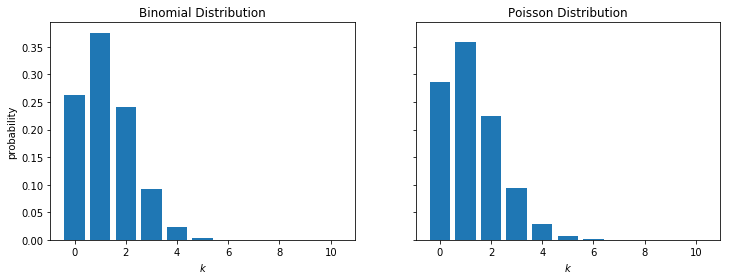

In [114]:
f, (ax1, ax2) = plt.subplots(1,2, figsize = (12,4), sharex = True, sharey = True)

ax1.bar(range(11), [binom(10,1/8).pmf(k) for k in range(11)])
ax1.set_title('Binomial Distribution')
ax1.set_xlabel("$k$")
ax1.set_ylabel("probability")

ax2.bar(range(11), [poisson(10/8).pmf(k) for k in range(11)])
ax2.set_title('Poisson Distribution')
ax2.set_xlabel("$k$");

## Testing

Let's redo the test of the observed distribution of points against the Poisson distribution.

In [115]:
probs = (gpd.sjoin(observed_points, base)
          .groupby('id')['id'].count()
          .value_counts(normalize = True)
          .sort_index()
          .rename('Observed Probability'))

theoretical = pd.Series([poisson(10/8).pmf(k).round(6) for k in range(11)], name = 'Predicted Probability')

counts = (gpd.sjoin(observed_points, base)
          .groupby('id')['id'].count()
          .value_counts()
          .sort_index()
          .rename('Observed Counts'))

# Multiply probabilites by 8 to get expected counts
expected = pd.Series([(poisson(10/8).pmf(k) * 8) for k in range(11)], name = 'Expected Counts')

# Make table
compare = pd.concat([probs,theoretical, counts, expected], axis=1).fillna(0)
compare

,Observed Probability,Predicted Probability,Observed Counts,Expected Counts
0,0.250,0.286505,2.0,2.292038
1,0.375,0.358131,3.0,2.865048
2,0.250,0.223832,2.0,1.790655
3,0.125,0.093263,1.0,0.746106
4,0.000,0.029145,0.0,0.233158
5,0.000,0.007286,0.0,0.058290
6,0.000,0.001518,0.0,0.012144
7,0.000,0.000271,0.0,0.002169
8,0.000,0.000042,0.0,0.000339
9,0.000,0.000006,0.0,0.000047


In [116]:
chi_test = chisquare(compare['Observed Counts'], compare['Expected Counts'])
(chi_test.statistic, chi_test.pvalue)

(0.46059058344761017, 0.9999955421150521)

Again, we conclude that the point pattern is random.